In [8]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import time
import matplotlib.pyplot as plt

In [10]:
device = 'cpu'

In [83]:
BATCH_SIZE = 100
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [84]:
dataset_dir = '/kaggle/input/antelope-rabbit/images/'  # Replace with your path to the 'images' directory
train_dir = os.path.join(dataset_dir, 'resized_train')
test_dir = os.path.join(dataset_dir, 'resized_test')

# Load the training and testing datasets using ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

# Create DataLoader instances for training and testing
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE,shuffle=False)

In [13]:
print(f"the length of our train loader is {len(train_loader)}\nAnd the size of our test loader is {len(test_loader)}")
print(f"the batch size is {BATCH_SIZE}")

the length of our train loader is 80
And the size of our test loader is 20
the batch size is 2


In [14]:
# i = 0
# for inputs, labels in train_loader:
#         if i == 1:
#             break
#         print(labels[0])
#         plt.plot(inputs[0])
#         i+=1
            

# Question (MLP Part)
Now, create an MLP model with parameters comparable to VGG16 and compare your performance with the other models in the table. You can choose the distribution of the number of neurons and the number of layers. What can you conclude? [0.5 marks]

Finally, use any image generation tool of your choice. Provide a prompt that helps easily classify your image; and provide a prompt that creates a hard to correctly classify image. Show the performance of various models on these sets of images. Minimum 4 such images can be created. Class A: easy, Class A: hard; Class B: easy, Class B: hard [1 mark]



## Batch size = 2 and LR = 0.001

In [15]:
#performance => test accuracy, training time, number of parameters, final loss 

# Define the MLP Model
class LargeMLP(nn.Module):
    def __init__(self):
        super(LargeMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(224 * 224 * 3, 1028),  #Input
            nn.ReLU(),
            nn.Linear(1028, 512), #one
            nn.ReLU(),
            nn.Linear(512, 512), #two 
            nn.ReLU(),
            nn.Linear(512, 512),#three 
            nn.ReLU(),
            nn.Linear(512, 512),#four 
            nn.ReLU(),
            nn.Linear(512, 512),#five
            nn.ReLU(),
            nn.Linear(512, 512),#six
            nn.ReLU(),
            nn.Linear(512, 512),#seven
            nn.ReLU(),
            nn.Linear(512, 512),#eight
            nn.ReLU(),
            nn.Linear(512, 512),#nine
            nn.ReLU(),
            nn.Linear(512, 256),#ten
            nn.ReLU(),
            nn.Linear(256, 256),#eleven
            nn.ReLU(),
            nn.Linear(256, 256),#twelve
            nn.ReLU(),
            nn.Linear(256, 256),#thirteen
            nn.ReLU(),
            nn.Linear(256, 128),#fourteen
            nn.ReLU(),
            nn.Linear(128, 64),#fifteen
            nn.ReLU(),
            nn.Linear(64, 32),#sixteen
            nn.ReLU(),
            nn.Linear(32, 1),  # Output layer for binary classification
            nn.Sigmoid()  # Sigmoid for binary output
        )
        
    def forward(self, x):
        return self.model(x)

In [21]:
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    total_start_time = time.time()  # Track total training time
    
    # Variables to track convergence
    prev_losses = []  # To store loss values for the last 3 epochs
    patience = 3      # Number of epochs to wait before stopping
    
    for epoch in range(epochs):
        epoch_start_time = time.time()  # Track start time for each epoch
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            
            # Forward pass
            outputs = model(inputs)
            # Ensure outputs have the same shape as labels (1D tensor)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        # Calculate epoch duration
        epoch_duration = time.time() - epoch_start_time
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Time: {epoch_duration:.2f} seconds")
        
        # Track loss for early stopping
        prev_losses.append(epoch_loss)
        if len(prev_losses) > patience:
            prev_losses.pop(0)  # Maintain a window of the last 'patience' losses
            
        # Check for increasing loss or convergence
        if len(prev_losses) == patience and prev_losses[-1] > prev_losses[-2] > prev_losses[-3]:
            print(f"Early stopping triggered at epoch {epoch+1}: Loss increased over {patience} epochs.")
            break
    
    # Calculate total training duration
    total_training_time = time.time() - total_start_time
    print(f"Total training time: {total_training_time:.2f} seconds")

In [79]:
#Testing function
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to('cpu'), labels.to('cpu')
            outputs = model(inputs)
            predictions = (outputs.squeeze() > 0.5).float()
            print(predictions)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [18]:
def save_model(model, learning_rate, epoch_count, BATCH_SIZE):
    path = f"/kaggle/working/mlp_final_{learning_rate}_{BATCH_SIZE}_{epoch_count}"
    torch.save(model.state_dict(), path)

In [34]:
# def run_all(train_data, test_data):
#     epoch_count = 10
#     bat_sizes = [1,4, 6]
#     lrs = [0.0005, 0.0001]
#     for batch in bat_sizes:
#         for lr in lrs:
            
#             # Create DataLoader instances for training and testing
#             train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
#             test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)
            
#             # Initialize the model, loss, and optimizer
#             model = LargeMLP()
#             criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss instead of BCELoss
#             optimizer = optim.Adam(model.parameters(), lr=lr)  # Dynamic learning rate
            
#             # Set device
#             device = 'cpu'
#             model.to(device)
            
#             # Run training
#             print(f"\nThe model has learning rate: {lr} and batch_size: {batch}\n")
#             train(model, train_loader, criterion, optimizer, epochs=epoch_count)
#             print("Test of this model is :")
#             test(model, test_loader)
#             print("\n\n")
            
#             # Save the model
#             save_model(model, lr, epoch_count, batch)

In [36]:
# run_all(train_data, test_data)

In [37]:
# Create DataLoader instances for training and testing
train_loader = DataLoader(train_data, batch_size=6, shuffle=True)
test_loader = DataLoader(test_data, batch_size=6, shuffle=False)

# Initialize the model, loss, and optimizer
model = LargeMLP()
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss instead of BCELoss
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Dynamic learning rate

# Set device
device = 'cpu'
model.to(device)

# Run training
print(f"\nThe model has learning rate: {0.0001} and batch_size: {6}\n")
train(model, train_loader, criterion, optimizer, epochs=15)
print("Test of this model is :")
test(model, test_loader)


The model has learning rate: 0.0001 and batch_size: 6

Epoch 1/15, Loss: 0.7288, Time: 36.85 seconds
Epoch 2/15, Loss: 0.7279, Time: 34.47 seconds
Epoch 3/15, Loss: 0.6736, Time: 35.16 seconds
Epoch 4/15, Loss: 0.6819, Time: 34.80 seconds
Epoch 5/15, Loss: 0.7076, Time: 34.75 seconds
Early stopping triggered at epoch 5: Loss increased over 3 epochs.
Total training time: 176.04 seconds
Test of this model is :
Test Accuracy: 60.00%





In [39]:
save_model(model, 0.0001, 15, 6) #3 min train time, if implemeneted with stopping condition. 

In [85]:
test(model, test_loader)

tensor([1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.])
Test Accuracy: 60.00%


# image generation 

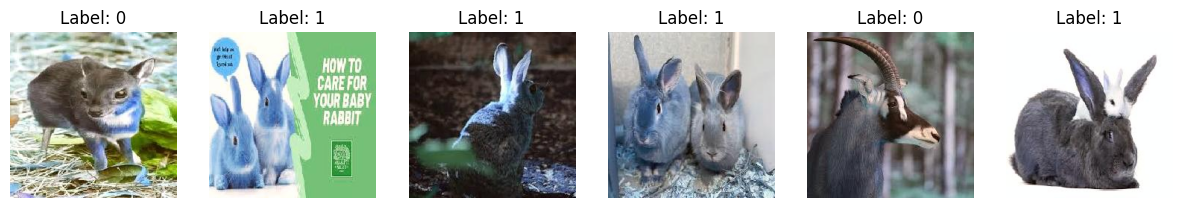

Labels: [0, 1, 1, 1, 0, 1]


In [70]:
# Get one batch of images and labels
for img, lb in train_loader:
    # Plot the 6 images in the batch
    fig, axes = plt.subplots(1, 6, figsize=(15, 5))
    for i in range(6):
        # Convert image tensor to numpy for visualization
        image = img[i].permute(1, 2, 0).numpy()  # Change shape from [C, H, W] to [H, W, C]
        
        # Ensure channels are properly ordered (PyTorch uses normalized values)
        if image.shape[2] == 3:  # Check if the image has 3 channels
            image = image[..., [0, 1, 2]]  # Explicitly order as RGB
        
        # Unnormalize if normalization was applied (assuming mean and std for normalization are known)
        mean = np.array([0.485, 0.456, 0.406])  # Example mean for ImageNet models
        std = np.array([0.229, 0.224, 0.225])   # Example std for ImageNet models
        image = std * image + mean  # Unnormalize
        image = np.clip(image, 0, 1)  # Clip to range [0, 1]

        # Plot the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(f"Label: {lb[i].item()}")
    plt.show()
    
    # Print the labels as a list
    print("Labels:", lb.tolist())
    break  # Break after one batch


In [50]:
from PIL import Image

In [64]:
folder_path = '/kaggle/input/image-generated'
label_mapping = {
    "antelope": 0,
    "rabbit": 1
}

# Initialize empty lists for images, labels, and file names
test_images = []
test_labels = []
file_names = []

# Iterate through the files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(('.png', '.jpg', '.jpeg')):  # Ensure it's an image
        # Load the image
        image_path = os.path.join(folder_path, file_name)
        image = Image.open(image_path).convert("RGB")  # Convert to RGB format
        
        # Resize the image (optional, standardize to a consistent size, e.g., 224x224)
        image = image.resize((224, 224))
        
        # Convert the image to a numpy array
        image_array = np.array(image)
        test_images.append(image_array)
        
        # Store the file name
        file_names.append(file_name)
        
        # Determine the label based on the file name
        if "antelope" in file_name.lower():
            test_labels.append(label_mapping["antelope"])
        elif "rabbit" in file_name.lower():
            test_labels.append(label_mapping["rabbit"])

# Convert lists to numpy arrays for easy handling
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Print out the dataset shape and file names for verification
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")
print(f"File Names: {file_names}")
print(f"Labels: {test_labels}")

Test Images Shape: (4, 224, 224, 3)
Test Labels Shape: (4,)
File Names: ['easy_rabbit.jpg', 'easy_antelope.jpg', 'hard_rabbit.jpg', 'hard_antelope.jpg']
Labels: [1 0 1 0]


In [65]:
# Initialize the model, loss, and optimizer
model_gen = LargeMLP()
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss instead of BCELoss
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Dynamic learning rate

#Set device
device = 'cpu'
model_gen.to(device)

#loading weights 
model_gen.load_state_dict(torch.load("/kaggle/working/mlp_final_0.0001_6_15", weights_only=True))

<All keys matched successfully>

In [66]:
from torch.utils.data import DataLoader, Dataset

In [67]:
# Define a custom Dataset class for the test set
class CustomTestDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label

In [76]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (use your model's normalization parameters)
])

# Create the test dataset and DataLoader
test_dataset_gen = CustomTestDataset(test_images, test_labels, transform=transform)
test_loader_gen = DataLoader(test_dataset_gen, batch_size=4, shuffle=False)

# Run inference using the binary classifier model_gen
model_gen.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gen = model_gen.to(device)  # Move model to device

# Inference loop
all_predictions = []
all_labels = []

with torch.no_grad():  # No need to compute gradients during inference
    for images, labels in test_loader_gen:
        images = images.to(device)  # Move images to the same device as the model
        labels = labels.to(device)  # Move labels to the same device

        # Perform inference
        outputs = model_gen(images)
        predictions = torch.round(torch.sigmoid(outputs)).squeeze()  # Apply sigmoid and round for binary classification

        # Store predictions and labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print predictions and corresponding ground truth
for idx, (pred, label) in enumerate(zip(all_predictions, all_labels)):
    print(f"Image {idx + 1}: Predicted: {int(pred)}, Ground Truth: {int(label)}")

Image 1: Predicted: 1, Ground Truth: 1
Image 2: Predicted: 1, Ground Truth: 0
Image 3: Predicted: 1, Ground Truth: 1
Image 4: Predicted: 1, Ground Truth: 0


In [69]:
# File Names: ['easy_rabbit.jpg', 'easy_antelope.jpg', 'hard_rabbit.jpg', 'hard_antelope.jpg']

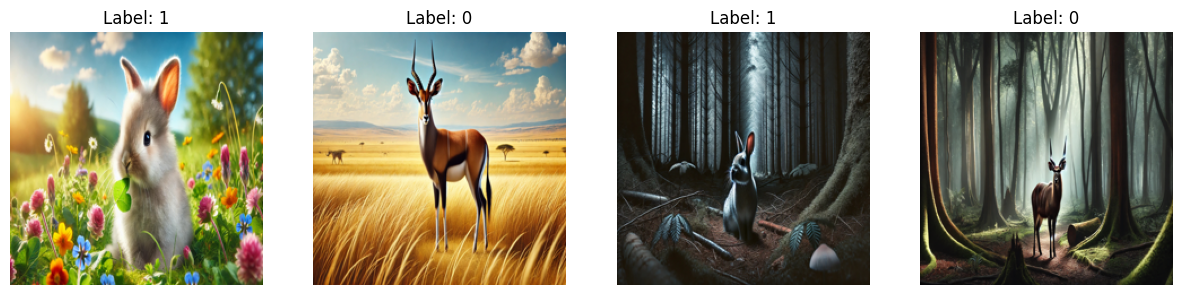

Labels: [1, 0, 1, 0]


In [78]:
# Get one batch of images and labels
for img, lb in test_loader_gen:
    # Plot the 6 images in the batch
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for i in range(4):
        # Convert image tensor to numpy for visualization
        image = img[i].permute(1, 2, 0).numpy()  # Change shape from [C, H, W] to [H, W, C]
        
        # Ensure channels are properly ordered (PyTorch uses normalized values)
        if image.shape[2] == 3:  # Check if the image has 3 channels
            image = image[..., [0, 1, 2]]  # Explicitly order as RGB
        
        # Unnormalize if normalization was applied (assuming mean and std for normalization are known)
        mean = np.array([0.485, 0.456, 0.406])  # Example mean for ImageNet models
        std = np.array([0.229, 0.224, 0.225])   # Example std for ImageNet models
        image = std * image + mean  # Unnormalize
        image = np.clip(image, 0, 1)  # Clip to range [0, 1]

        # Plot the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(f"Label: {lb[i].item()}")
    plt.show()
    
    # Print the labels as a list
    print("Labels:", lb.tolist())
    break  # Break after one batch
